<a href="https://colab.research.google.com/github/danielhou13/cogs402longformer/blob/main/Huggingfacetutorial/CaptumLongformerSequenceClassificationPapersLayers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/{}'.format("cogs402longformer/"))

In [ ]:
pip install transformers --quiet

In [ ]:
pip install captum --quiet

In [ ]:
pip install datasets --quiet

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig

from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

import torch

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import LongformerForSequenceClassification, LongformerTokenizer, LongformerConfig
# replace <PATH-TO-SAVED-MODEL> with the real path of the saved model
model_path = '/content/drive/MyDrive/cogs402longformer/models/longformer-finetuned_papers/checkpoint-2356'

# load model
model = LongformerForSequenceClassification.from_pretrained(model_path, num_labels = 2)
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")

In [ ]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [ ]:
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, truncation = True, add_special_tokens=False, max_length = 512)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids

def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

In [ ]:
from datasets import load_dataset
cogs402_ds = load_dataset("danielhou13/cogs402dataset")["test"]

Using custom data configuration danielhou13--cogs402dataset-cc784554b797f843
Reusing dataset parquet (/root/.cache/huggingface/datasets/danielhou13___parquet/danielhou13--cogs402dataset-cc784554b797f843/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
testval = 923
text = cogs402_ds['text'][testval]
label = cogs402_ds['labels'][testval]
print(label)

0


In [ ]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

In [ ]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [ ]:
print(len(all_tokens))

514


In [ ]:
#set 1 if we are dealing with a positive class, and 0 if dealing with negative class
def custom_forward2(inputs_emb, global_attention_mask) :
    preds = model(inputs_embeds=inputs_emb, global_attention_mask=global_attention_mask)
    return torch.softmax(preds.logits, dim = 1)[:, 0] # for negative attribution, 
    #return torch.softmax(preds, dim = 1)[:, 1] #<- for positive attribution

In [ ]:
def construct_whole_longformer_embeddings(input_ids, ref_input_ids, \
                                          token_type_ids=None, ref_token_type_ids=None, \
                                          position_ids=None, ref_position_ids=None):
    input_embeddings = model.longformer.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.longformer.embeddings(ref_input_ids, token_type_ids=ref_token_type_ids, position_ids=ref_position_ids)
    
    print(input_embeddings.shape)
    return input_embeddings, ref_input_embeddings

In [ ]:
layer_attrs = []

# The token that we would like to examine separately.
token_to_explain = 314 # the index of the token that we would like to examine more thoroughly
layer_attrs_dist = []

input_embeddings, ref_input_embeddings = construct_whole_longformer_embeddings(input_ids, ref_input_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)

globalattention= torch.zeros_like(input_ids)
globalattention[:, 0] = 1

torch.Size([1, 514, 768])


In [ ]:
for i in range(model.config.num_hidden_layers):
    print(i)
    lc = LayerConductance(custom_forward2, model.longformer.encoder.layer[i])
    layer_attributions = lc.attribute(inputs=input_embeddings, 
                                      baselines=ref_input_embeddings, 
                                      additional_forward_args=globalattention, 
                                      n_steps=10, 
                                      internal_batch_size=2)
    layer_attrs.append(summarize_attributions(layer_attributions[:,:514,:]).cpu().detach().tolist())

    # storing attributions of the token id that we would like to examine in more detail in token_to_explain
    layer_attrs_dist.append(layer_attributions[0,token_to_explain,:].cpu().detach().tolist())


0
1
2
3
4
5
6
7
8
9
10
11


In [ ]:
print(len(layer_attrs[0]))

514


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(250,75))
xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(np.array(layer_attrs), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2, annot=True)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

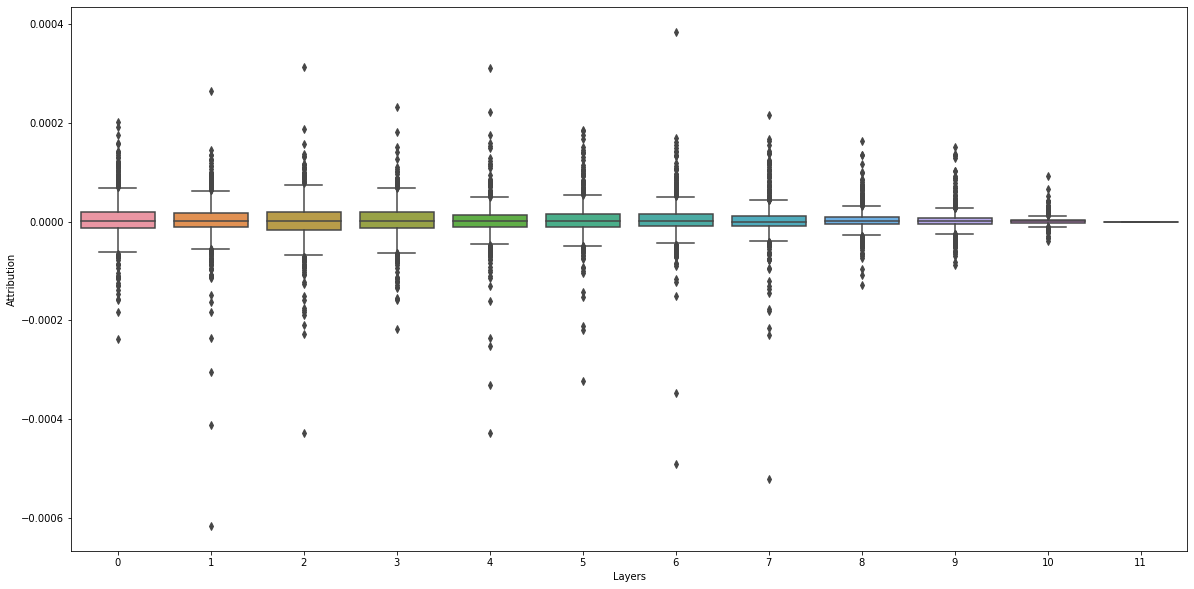

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

In [ ]:
def pdf_attr(attrs, bins=100):
    return np.histogram(attrs, bins=bins, density=True)[0]

In [ ]:
layer_attrs_pdf = map(lambda layer_attrs_dist: pdf_attr(layer_attrs_dist), layer_attrs_dist)
layer_attrs_pdf = np.array(list(layer_attrs_pdf))

# summing attribution along embedding diemension for each layer
# size: #layers
attr_sum = np.array(layer_attrs_dist).sum(-1)

# size: #layers
layer_attrs_pdf_norm = np.linalg.norm(layer_attrs_pdf, axis=-1, ord=1)

#size: #bins x #layers
layer_attrs_pdf = np.transpose(layer_attrs_pdf)

#size: #bins x #layers
layer_attrs_pdf = np.divide(layer_attrs_pdf, layer_attrs_pdf_norm, where=layer_attrs_pdf_norm!=0)

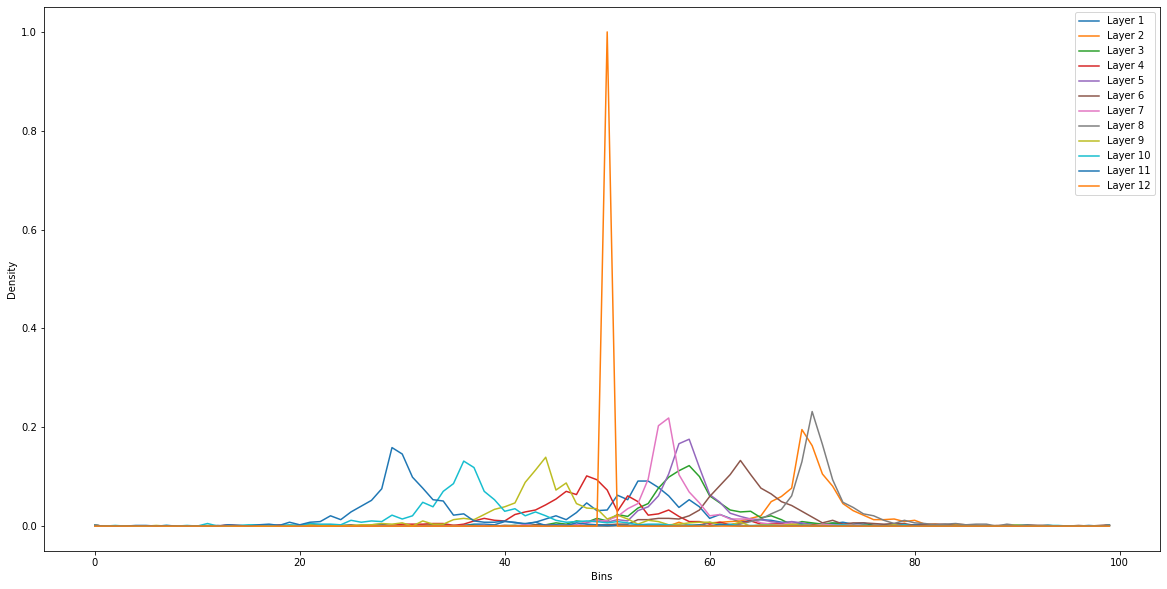

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(layer_attrs_pdf)
plt.xlabel('Bins')
plt.ylabel('Density')
plt.legend(['Layer '+ str(i) for i in range(1,13)])
plt.show()

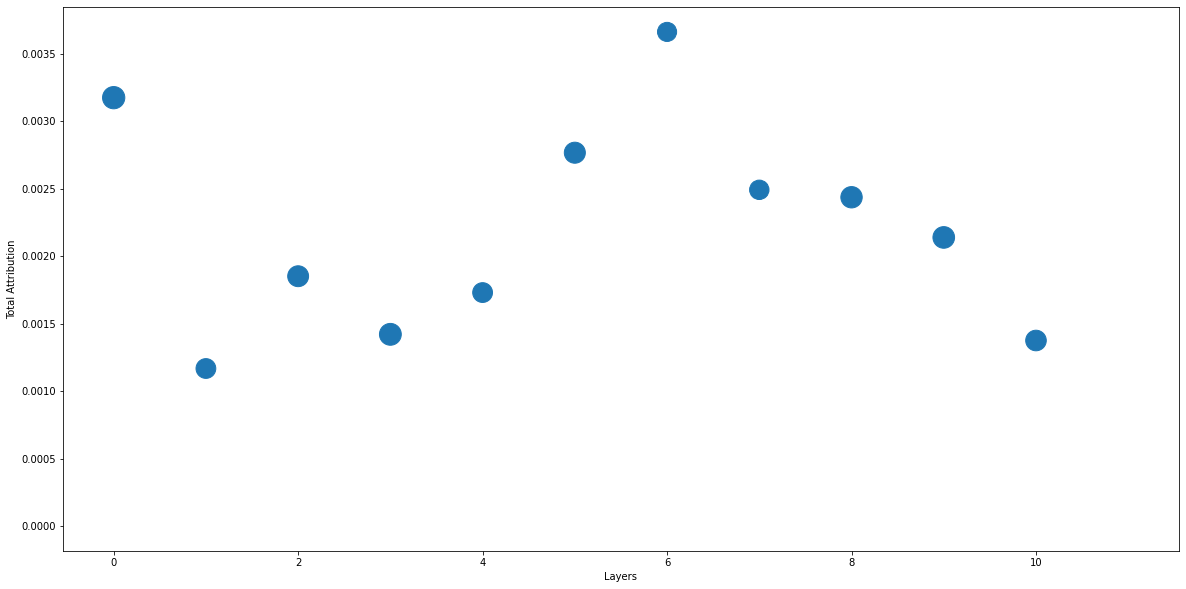

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

# replacing 0s with 1s. np.log(1) = 0 and np.log(0) = -inf
layer_attrs_pdf[layer_attrs_pdf == 0] = 1
layer_attrs_pdf_log = np.log2(layer_attrs_pdf)

# size: #layers
entropies= -(layer_attrs_pdf * layer_attrs_pdf_log).sum(0)

plt.scatter(np.arange(12), attr_sum, s=entropies * 100)
plt.xlabel('Layers')
plt.ylabel('Total Attribution')
plt.show()